In [170]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
import datasets
import numpy as np

pl.seed_everything(89026614)

text = datasets.load_dataset('tiny_shakespeare')["train"][0]["text"]
#text = open('../../Downloads/simplebooks/simplebooks-2-raw/train.txt', 'r').read()

Global seed set to 89026614
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 1033.33it/s]


In [171]:
device = "cpu"
block_size = 100

class MyDataset(data.Dataset):
    def __init__(self, text):
        super().__init__()
        vocab = sorted(set(text))
        self.vocab = vocab
        self.stoi = { ch: i for i, ch in enumerate(vocab) }
        self.itos = { i: ch for i, ch in enumerate(vocab) }
        self.data = torch.tensor([self.stoi[ch] for ch in text], dtype=torch.long).to(device)

    def __len__(self):
        return self.data.size(0) - block_size - 1

    def __getitem__(self, i):
        end = i + block_size
        return self.data[i:end], self.data[i + 1:end + 1]

dataset = MyDataset(text)
train = data.Subset(dataset, range(0, len(dataset) - 500))
test = data.Subset(dataset, range(len(dataset) - 500, len(dataset)))

In [172]:
# inspired by https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
class MinGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, dropout):
        super().__init__()
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Dropout(dropout),
            nn.Sequential(*[DecoderLayer(embed_dim, dropout) for _ in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

    @torch.no_grad()
    def generate(self, input_ids, max_new_tokens, top_k=10):
        for _ in range(max_new_tokens):
            out = self(input_ids[:, -block_size:])
            logits = out[:, -1, :]
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float("Inf")
            step_res = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
            # auto-regression
            input_ids = torch.cat((input_ids, step_res), dim=1)

        return input_ids

class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTFlat(embed_dim, dropout)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).to(device))

    def forward(self, x):
        B, T, _ = x.shape
        x = self.ln1(x)
        x = x + self.attn(x, self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# inspired by https://arxiv.org/pdf/2105.14103.pdf and https://github.com/BlinkDL/RWKV-LM
# but RWKV is way more advanced (and better)
#
# when compared to AFT paper:
# - the main idea is still just weighted average
# - looking at plotted attentions, it's mostly diagonal, so there's a lot of waste
# - so let's make `w` a flat vector (and don't exponentiate it for the numerator part)
# - divide by a cumulative sum of exp(k)
class AFTFlat(nn.Module):
    def __init__(self, embed_dim, dropout):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        # init with decay as this is what network learns anyway
        self.w = nn.Parameter((1 + torch.arange(block_size, dtype=torch.float)).softmax(dim=0), requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        exp_k = k.clamp(max=20).exp()
        wkv = torch.einsum("tk,bkc->btc", circulant.apply(self.w)[:T, :T] * mask, exp_k * v)
        Yt = F.sigmoid(q) * wkv / torch.cumsum(exp_k, dim=1)
        return self.drop(self.proj(Yt))

# it's not enough to compute the circulant matrix from the 1D input,
# we also need to make the gradient flow back (like if it was pointing directly to vector)
class circulant(torch.autograd.Function):
    @staticmethod
    def forward(ctx, t):
        ctx.save_for_backward(t)
        return torch.cat([t, t[:-1]]).unfold(0, len(t), 1).flip(0)

    @staticmethod
    def backward(ctx, grad_out):
        t, = ctx.saved_tensors
        grad_t, l = torch.zeros_like(t), len(t)
        for i in range(l): # just the bottom part, but indices are reversed!
            grad_t[l - 1 - i] = torch.sum(torch.diagonal(grad_out, offset=-i))
        return grad_t

class Model(pl.LightningModule):
    def __init__(self, vocab_size, lr=0.004):
        super().__init__()
        self.lr = lr
        self.model = MinGPT(vocab_size, embed_dim=192, num_layers=3, dropout=0.1)
    
    def forward(self, x, y=None):
        logits = self.model(x)
        return logits if y is None else F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)

    def train_dataloader(self):
        return data.DataLoader(train, batch_size=100, num_workers=0, sampler=data.RandomSampler(train, False, 5_000))

    def training_step(self, batch, batch_idx):
        return self(*batch)

    def val_dataloader(self):
        return data.DataLoader(test, batch_size=16, num_workers=0)
    
    def validation_step(self, batch, batch_idx):
        loss = self(*batch)
        self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_epoch_end(self, outs):
        with torch.no_grad():
            x = torch.tensor([dataset.stoi[s] for s in "And now "], dtype=torch.long)[None,...].to(device)
            y = self.model.generate(x, 64)[0]
            print("".join([dataset.itos[int(i)] for i in y]))

    def configure_optimizers(self):
        optim = torch.optim.AdamW(self.parameters(), lr=self.lr)
        sched = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.999, last_epoch=-1)
        return [optim], [sched]

model = Model(len(dataset.vocab))
trainer = pl.Trainer(gradient_clip_val=1.0, max_epochs=25, enable_progress_bar=True, accelerator="gpu" if device == "cuda" else "cpu")
trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | MinGPT | 1.4 M 
---------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.432     Total estimated model params size (MB)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 44.24it/s]And now &uZJlByjL&mutnE;!lIeug ?BDnVGUPFthAQAx-iafozWS&HjfxAIE3N.C3NQ
gB
Epoch 1: 100%|██████████| 82/82 [00:18<00:00,  4.52it/s, loss=1.91, v_num=284, test_loss=2.110]And now thy see by me.

DUKE VILLA:
In my hims way, my feeld show my sin
Epoch 2: 100%|██████████| 82/82 [00:18<00:00,  4.54it/s, loss=1.76, v_num=284, test_loss=1.920]And now is signed;
What so most one.

First shall which as indies, and m
Epoch 3: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s, loss=1.67, v_num=284, test_loss=1.820]And now bance these to heard.

GLOUCESTER:
And stry a purgers: the sacki
Epoch 4: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s, loss=1.62, v_num=284, test_loss=1.700]And now the barry'st that much, which which.

LORGARET:
What mercia, and
Epoch 5: 100%|██████████| 82/82 [00:18<00:00,  4.53it/s, loss=1.58, v_num=284, test_loss=1.610]And now steep!
But what your wounder me soun and in they.

POLIXENES:
No
Epoch 6: 100

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 82/82 [00:18<00:00,  4.54it/s, loss=1.35, v_num=284, test_loss=1.370]


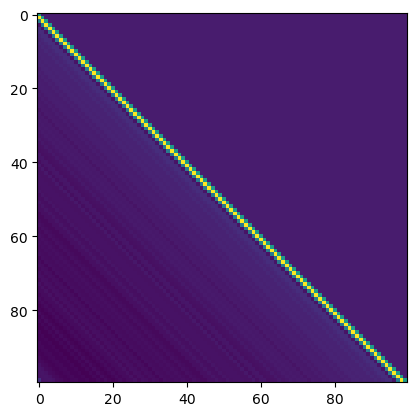

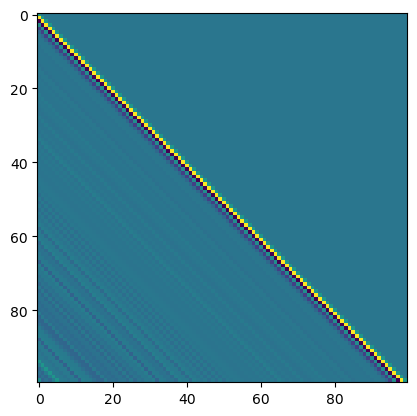

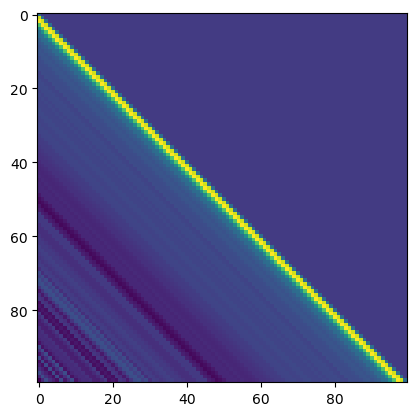

In [173]:
from matplotlib import pyplot as plt
for b in model.model.transformer[2]:
    w = circulant.apply(b.attn.w).detach() * torch.tril(torch.ones(block_size, block_size))
    plt.figure()
    plt.imshow(w.detach())

In [174]:
y = model.to(device).model.generate(torch.tensor([dataset.stoi[s] for s in "O God, O God!"]).unsqueeze(0).to(device), 650)
print("".join([dataset.itos[int(i)] for i in y[0]]))

O God, O God!

CAMILLO:
This, was a fair suitor, they with more a world sit
I'll send thy swolved by an seeming;
Thou change to-night my mothes serves our hounsward
To murder the hatred again; and I with not safe we
are their will.'

CAMILLO:
Where is that niw!

PRINCE:
And blest not so die!
I plain my palamis that may let a beg, that?
Our three-day boldly that in the most time
That serve of me.

First Gentleman:
But yet: must with me now!

ESCALUS:
Methink me sentence to the king should stranged of hide
Whom If I choose hold above that I may do't,
See impart him or me.
O sad my love, two cat I was mocked for me,
Which this face, make you may, and I prize
